## Imports

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date
from pylab import plt, mpl
import mplfinance as mpf
plt.style.use('seaborn-v0_8-notebook')
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(precision=4, suppress=True)
os.environ['PYTHONHASHSEED'] = '0'
%config InlineBackend.figure_format = 'svg'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4' # can also be set in bashrc

from predictor.env import Finance
from predictor.agent import DQLAgent
from predictor.utils import visualize, save_params

Num GPUs Available:  1


In [2]:
import warnings as w
w.simplefilter('ignore')

In [3]:
ticker = ['sinus_noise_std_1'] # must be given as a list, use sinus data to check model
interval = '3m' # roughly 300 min per period
train_days = 1
test_days = 1
#features = [('log-ret', 'z'), ('ratio_sma_20_40', 'z'), ('hour_otd', 'minmax'), ('volume', 'minmax')]
#features = [('log-ret', 'z'), ('ratio_sma_12_24', 'z'), ('hour_otd', 'minmax')]
#features = [('log-ret', 'z'), ('ratio_sma_20_40', 'z'), ('volume', 'minmax')]
#features = [('log-ret', 'z'), ('ratio_sma_12_24', 'z')]
#features = [('log-ret', 'z'), ('close_5_sma', 'z')]
#features = [('log-ret', 'z'), ('close_12_sma', 'z'), ('close_24_sma', 'z')]
#features = [('log-ret', 'z') , ('hour_otd', 'minmax')]
features = [('log-ret', 'z')]


#features = [('ratio_sma_12_24', 'z')]
#features = [('candle_body', 'z'), ('upper_wick', 'z'), ('lower_wick', 'z')]

lags = 100
END_TEST = date.today()
START_TEST = END_TEST - timedelta(days=test_days)
END_TRAIN = START_TEST
START_TRAIN = END_TRAIN - timedelta(days=train_days)
print(f"Training period: {START_TRAIN} to {END_TRAIN}")
print(f"Testing period: {START_TEST} to {END_TEST}")

Training period: 2024-01-31 to 2024-02-01
Testing period: 2024-02-01 to 2024-02-02


In [4]:
train_env = Finance(ticker, interval, features, lags, min_performance = 0.75, min_sharpe=0.4,
                 start=START_TRAIN, end=END_TRAIN)
train_env.seed(42)

Successfully added log-ret to DataFrame



In [5]:
train_env.data.head()

,date,close,log-ret,log-ret-no-scale,dir
1,2024-01-31 00:06:00,102.348517,-0.037868,-0.000832,0
2,2024-01-31 00:09:00,107.087599,2.318034,0.045263,1
3,2024-01-31 00:12:00,104.259034,-1.363446,-0.026769,0
4,2024-01-31 00:15:00,106.268961,0.980584,0.019095,1
5,2024-01-31 00:18:00,104.354118,-0.924650,-0.018183,0


<Axes: >

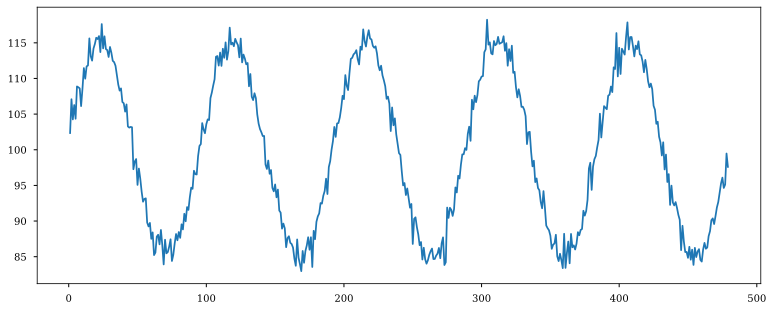

In [6]:
train_env.data['close'].plot(figsize=(13,5))

In [7]:
test_env = Finance(ticker, interval, features,
                 lags, min_performance=train_env.min_performance,
                 start=START_TEST, end=END_TEST)

Successfully added log-ret to DataFrame



In [8]:
hu = max(lags, 24) # hidden_units
lr = 0.0001 # learing_rate
batch = True
agent = DQLAgent(hu, lr, batch, train_env, test_env)
print('Done')

Done


In [9]:
agent.value_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 2)                 52        
                                                                 
Total params: 31927 (124.71 KB)
Trainable params: 31927 (124.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
episodes = 10
%time agent.learn(episodes)

episode:   1/10  | loss: 0.18068 | perf:  29.291% | endurance:  379 | total reward:  22.13 | epsilon: 0.98
episode:   2/10  | loss: 0.18411 | perf:  87.110% | endurance:  379 | total reward:  35.06 | epsilon: 0.96
episode:   3/10  | loss: 0.17899 | perf: -21.236% | endurance:  379 | total reward:   4.60 | epsilon: 0.94
episode:   4/10  | loss: 0.18213 | perf: -25.611% | endurance:  191 | total reward: -14.83 | epsilon: 0.92
episode:   5/10  | loss: 0.18388 | perf:  47.367% | endurance:  379 | total reward:   9.27 | epsilon: 0.9
episode:   6/10  | loss: 0.18512 | perf: -28.204% | endurance:  129 | total reward:  -7.18 | epsilon: 0.89
episode:   7/10  | loss: 0.17399 | perf:  32.110% | endurance:  379 | total reward:  12.92 | epsilon: 0.87
episode:   8/10  | loss: 0.18022 | perf: -12.905% | endurance:  379 | total reward:   2.17 | epsilon: 0.85
episode:   9/10  | loss: 0.18426 | perf:  44.218% | endurance:  379 | total reward:   5.43 | epsilon: 0.83
episode:  10/10  | loss: 0.18435 | per

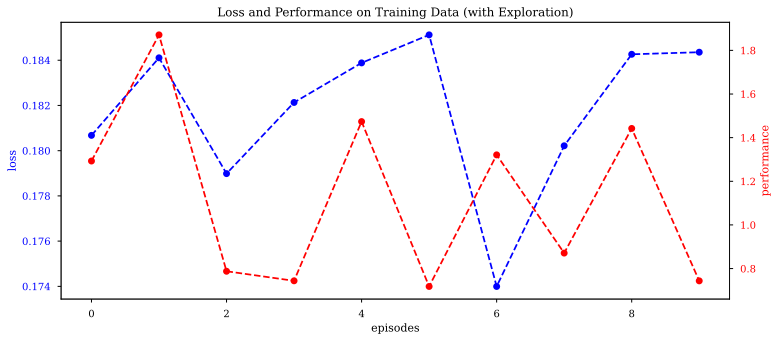

In [11]:
# Create a figure and the first y-axis
fig, ax1 = plt.subplots(figsize=(12, 5))

# Data for the first y-axis
x = range(1, len(agent.losses) + 1)
#y = np.polyval(np.polyfit(x, agent.losses, deg=3), x)
ax1.plot(agent.losses, 'bo--', label='loss')
ax1.set_xlabel('episodes')
ax1.set_ylabel('loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()

# Data for the second y-axis
ax2.plot(agent.performances, 'ro--', label='performance')
ax2.set_ylabel('performance', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Loss and Performance on Training Data (with Exploration)')
plt.show()

In [12]:
actions = []
length = len(test_env.data) - test_env.lags

for i in range(length):
    state = test_env.reset(shift=i)
    state = np.reshape(state, [1, test_env.lags,
                                   test_env.n_features])
    action = agent.value_model.predict(state, verbose=0)[0]
    if i%10==0:
        print(f'progress: {i:>4d}/{length:>4d}', end='\r')
    actions.append(np.argmax(action))

data = pd.DataFrame({
    'date' : test_env.data['date'].tail(length).reset_index(drop=True),
    'close' : test_env.data['close'].tail(length).reset_index(drop=True),
    'log-ret-ns': test_env.data['log-ret-no-scale'].tail(length).reset_index(drop=True),
    'action': actions
})
data['action'].replace(0, -1, inplace=True)
data['performance'] = (data['log-ret-ns'] * data['action']).cumsum().apply(lambda x: np.exp(x))
# paramters to save 
buy_and_hold = (data['close'].iloc[-1] / data['close'].iloc[0] - 1) * 100
perf_on_test = ((data['performance'].iloc[-1]-1) * 100) 

text = 'Buy-and-hold strategy: {:4.1f}% \n'
text += 'DRL strategy out of sample: {:4.1f}%'
print(text.format(buy_and_hold, perf_on_test))

Buy-and-hold strategy: -4.8% 
DRL strategy out of sample: 12.5%


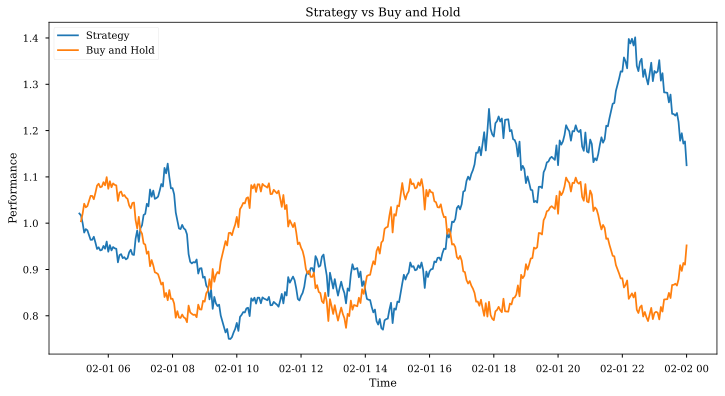

In [13]:
# Plot performance vs buy-and-hold strategy 
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['performance'], label='Strategy')
plt.plot(data['date'], data['close'].pct_change().apply(lambda x : x+1).cumprod(), label='Buy and Hold')
plt.title('Strategy vs Buy and Hold')
plt.xlabel('Time')
plt.ylabel('Performance')
plt.legend()
plt.show()

#### Visualize entry and exit points

In [14]:
#display figure
chart = visualize(data)
chart

alt.LayerChart(...)

In [15]:
# save figure
figname = 'filename-goes-here.html'
chart.save(figname)

#### Save parameters to file

In [16]:
filename = 'filename-goes-here.csv'
comment = 'add you comment here'
# Append the parameters to the file
save_params(filename, ticker, test_env.features, lags, episodes, lr, 
            agent.tau, agent.gamma, agent.epsilon_decay, buy_and_hold, perf_on_test, comment)